In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AMDC import AMDC
from AMDC_Logger import AMDC_Logger
import time
import pathlib as pl
import pandas as pd
import struct
import time

In [2]:
mapfile = pl.Path(r'C:\Users\Nathan\Documents\GitHub\AMDC-Firmware\sdk\bare\user\Debug\mapfile.txt')
c_code_root = pl.Path(r'C:\Users\Nathan\Documents\GitHub\AMDC-Firmware\sdk\bare')

amdc = AMDC(port = 'COM3', cmdEcho = True)
logger = AMDC_Logger(AMDC = amdc, mapfile = mapfile)

In [3]:
amdc.connect()

In [7]:
amdc.disconnect()

In [4]:
log_vars = 'vsi_a vsi_b vsi_c'
logger.register(log_vars, samples_per_sec = 10000)
#logger.auto_register(c_code_root, samples_per_sec = 10000)

	> log reg 0 LOG_vsi_a 1179848 10000 double
['log reg 0 LOG_vsi_a 1179848 10000 double', 'SUCCESS']
	> log reg 1 LOG_vsi_b 1179856 10000 double
['log reg 1 LOG_vsi_b 1179856 10000 double', 'SUCCESS']
	> log reg 2 LOG_vsi_c 1179864 10000 double
['log reg 2 LOG_vsi_c 1179864 10000 double', 'SUCCESS']


In [5]:
logger.clear_all()

	> log empty 0
['log empty 0', 'SUCCESS']
	> log empty 1
['log empty 1', 'SUCCESS']
	> log empty 2
['log empty 2', 'SUCCESS']


In [5]:
logger.log(duration = 2)

	> log start
['log start', 'SUCCESS']
	> log stop
['log stop', 'SUCCESS']


	> log dump bin 31


In [16]:
var = "LOG_vsi_a"

# Start dumping to host
amdc.captureOutput = False
amdc.cmd("log dump bin 3")
amdc.captureOutput = True

# These are repeating 4 times in the binary stream!
MAGIC_HEADER = 0x12345678
MAGIC_FOOTER = 0x11223344

magic_header_idx = 0
magic_footer_idx = 0

dump_data = bytearray()
dump_data_idx = 0

start_time = time.time()
timeout_sec = 30 # about 1kSPS

found_footer = False
while not found_footer:   
    # Read in all serial data from OS buffer
    out = bytes(amdc.ser.read_all())
    dump_data += out
    
    N = len(out)
    
    s = struct.Struct('<IIII')    

    for i in range(0,N-s.size):
        magic = s.unpack(out[i:i+s.size])
        
        if magic[0] == MAGIC_HEADER and magic[1] == MAGIC_HEADER and magic[2] == MAGIC_HEADER and magic[3] == MAGIC_HEADER:
            magic_header_idx = dump_data_idx
            
        if magic[0] == MAGIC_FOOTER and magic[1] == MAGIC_FOOTER and magic[2] == MAGIC_FOOTER and magic[3] == MAGIC_FOOTER:
            magic_footer_idx = dump_data_idx
            found_footer = True
            break
        
        dump_data_idx += 1

    if not found_footer:
        # Sleep for 100 ms to let OS do other work if needed
        time.sleep(0.1)

        # Break loop if timeout
        if time.time() >= start_time + timeout_sec:
            print("ERROR: couldn't find magic footer!")
            break

end_time = time.time()

# Flush the host OS to make sure all
# serial data is out of buffers
# (this might be necessary to get last sample value!)
for i in range(0,10):
    out = bytes(amdc.ser.read_all())
    dump_data += out
            
print("magic_header_idx:", magic_header_idx)
print("magic_footer_idx:", magic_footer_idx)

print("Dump took:", '{:f}'.format(end_time - start_time), " sec")

	> log dump bin 3
magic_header_idx: 26
magic_footer_idx: 159235
Dump took: 19.818918  sec


In [17]:
N = len(dump_data)
bout = bytes(dump_data)

metadata_start_idx = magic_header_idx+(4*4)

s = struct.Struct("<II")
unpacked_header = s.unpack(bout[metadata_start_idx:metadata_start_idx+s.size])
num_samples  = unpacked_header[0]
data_type    = unpacked_header[1]

print("num samples:", hex(num_samples), num_samples)
print("data type:", hex(data_type), data_type)

num samples: 0x4f42 20290
data type: 0x3 3


In [18]:
dump_samples_idx = metadata_start_idx+s.size+1

if data_type == 1:
    s = struct.Struct('<Ii')
elif data_type == 2 or data_type == 3:
    s = struct.Struct('<If')
else:
    print("ERROR: unknown data type!")

samples = []
    
for i in range(0,num_samples):   
    sample = s.unpack(bout[dump_samples_idx:dump_samples_idx+s.size])
    dump_samples_idx += s.size
    
    ts  = sample[0]/1e6
    val = sample[1]
    
    # FIXME(NP): we shouldn't need to do this.... :(
    if i != 0:
        samples.append([ts, val])

In [19]:
# Convert to DataFrame

arr = np.array(samples)
df = pd.DataFrame(data = arr, columns = ['t', var[4::]])
df['t'] = df['t'] - df['t'].min()
df.set_index('t', inplace = True)

In [20]:
df['vsi_a']

t
0.0000    0.265938
0.0001    0.194599
0.0002    0.121316
0.0003    0.046821
0.0004   -0.028142
            ...   
2.0284    0.742717
2.0285    0.728597
2.0286    0.707198
2.0287    0.678732
2.0288    0.643485
Name: vsi_a, Length: 20289, dtype: float64

(0.0, 0.25)

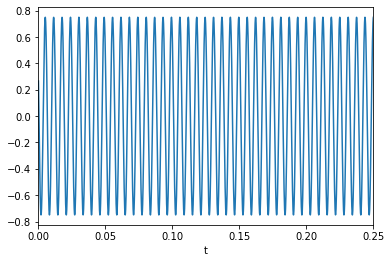

In [26]:
ax = df['vsi_a'].plot()
ax.set_xlim([0, 0.25])

In [6]:
out = logger.dump()

	> log dump bin 0
magic_header_idx: 26
magic_footer_idx: 159139
Dump took: 19.857759  sec
num samples: 0x4f36 20278
data type: 0x3 3
	> log dump bin 1
magic_header_idx: 26
magic_footer_idx: 159139
Dump took: 19.781481  sec
num samples: 0x4f36 20278
data type: 0x3 3
	> log dump bin 2
magic_header_idx: 26
magic_footer_idx: 159139
Dump took: 19.783420  sec
num samples: 0x4f36 20278
data type: 0x3 3


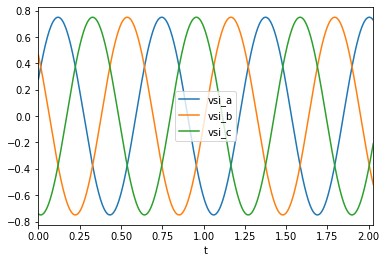

In [7]:
out.plot()

In [ ]:
out = logger.dump('data_logging/levitate', timestamp = True)

In [ ]:
ax = out['x y z'.split()].multiply(1000).plot();
ax.set_ylabel('Displacement [mm]');

In [ ]:
time.sleep(4)
cramb.levitate()
time.sleep(6)
cramb.stop_levitate()

In [ ]:
cramb.stop_levitate()

In [ ]:
run1 = pd.read_csv('data_logging/startup_1.csv')
run2 = pd.read_csv('data_logging/startup_2.csv')
run3 = pd.read_csv('data_logging/startup_3.csv')
run4 = pd.read_csv('data_logging/startup_4.csv')
lev1 = pd.read_csv('data_logging/levitate_1.csv')

In [ ]:
lev2['x y z'.split()].plot();

In [ ]:
lev['Fx_star Fy_star Fz_star'.split()].plot();

In [ ]:
cramb.read_position()

In [ ]:
run1['x_star y_star z_star'.split()].plot();

In [ ]:
run1['Fx_star Fy_star Fz_star'.split()].plot();

In [ ]:
run2['Ix_star Iy_star Iz_star'.split()].plot();

In [ ]:
ax = out['Va_star Vb_star Vc_star'.split()].plot()

In [ ]:
run3['x y z'.split()].plot();

In [ ]:
run3['Ix Iy Iz'.split()].plot();

In [ ]:
run4['Fx_star Fy_star Fz_star'.split()].plot();

In [ ]:
run4['Ix_star Iy_star Iz_star'.split()].plot();

In [ ]:
out = cramb.set_currents_3phase(1, -0.5, 5)
cramb.enable_current_control(5)
time.sleep(1)

logger.log(duration = 0.25)

time.sleep(1)
cramb.zero()

In [ ]:
%%script false
inv = 5
cramb.set_currents_3phase(Ia = 1, Ib = -0.5, inverter = inv)

cramb.enable_current_control(inv)
time.sleep(4)
cramb.disable_current_control(inv)

In [ ]:
%%script false
inv = 1
cramb.set_currents_1phase(1, inverter = inv)

cramb.enable_current_control(inv)
time.sleep(4)
cramb.disable_current_control(inv)

In [ ]:
out

In [ ]:
cramb.read_position()

In [ ]:
cramb.read_position()

In [ ]:
cramb.stop_callback()
cramb.disconnect()

In [ ]:
%%script false
def cc_gain_calc(R, L, fb):

    wb = 2*np.pi*fb
    kp = L*wb
    ki = R*wb
    
    return kp, ki  

Set up inverter gains for test RL load